# Mounting Google Drive and Download Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !gdown "1a8rYaLRKn_LSRmmz-IFsMxKfoByTVQKC"

In [ ]:
# !gdown "1--ujXmeuSP0jvG-tMX1YzvB2G5ozt3oH"

In [2]:
!gdown "1-AejrXJTnag0yNbKv4WDeAmXAgH211tj"

Downloading...
From: https://drive.google.com/uc?id=1-AejrXJTnag0yNbKv4WDeAmXAgH211tj
To: /content/model_checkpoint.pth
100% 375M/375M [00:07<00:00, 47.7MB/s]


In [3]:
!chmod 600 /content/drive/MyDrive


In [ ]:
!cp /content/model_checkpoint.pth /content/drive/MyDrive/

In [ ]:
# !cp /content/model_epoch_2.pt /content/drive/MyDrive/

In [4]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00


In [ ]:
# !pip install -q monai

In [6]:

!pip install kaggle

!mkdir /root/.kaggle



!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/




In [21]:
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

!chmod 600 /root/.kaggle/kaggle.json

!unzip satellite-images-of-water-bodies.zip

Streaming output truncated to the last 5000 lines.
  inflating: Water Bodies Dataset/Images/water_body_1808.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1809.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1810.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1811.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1812.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1813.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1814.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1815.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1816.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1817.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1818.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1819.jpg  
  inflating: Water Bodies Dataset/Images/water_body_182.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1820.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1822.jpg  
  inf

In [ ]:
# !cp -r /content/WaterBodiesDataset /content/drive/MyDrive

In [22]:
import torch
device = "cuda" if torch.cuda.is_available else "cpu"

In [23]:
img_path="Water Bodies Dataset/Images"
msk_path="Water Bodies Dataset/Masks"

In [10]:
!ls

drive  model_checkpoint.pth  sample_data


# Data Augmentation


In [24]:
import albumentations as A
import cv2
import os
import numpy as np
output_img_folder = "Augmented/Images"
output_msk_folder = "Augmented/Masks"

# Define non-destructive transformations using D4 group
aug = A.Compose([
    A.RandomRotate90(p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Transpose(p=0.5),
])

image_paths = [os.path.join(img_path, filename) for filename in sorted(os.listdir(img_path))]
label_paths = [os.path.join(msk_path, filename) for filename in sorted(os.listdir(msk_path))]

os.makedirs(output_img_folder, exist_ok=True)
os.makedirs(output_msk_folder, exist_ok=True)
for img_path, label_path in zip(image_paths, label_paths):
    image = cv2.imread(img_path)
    label = cv2.imread(label_path)

    msk_gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)

    img_resized = cv2.resize(image, (256,256))
    msk_resized = cv2.resize(msk_gray, (256,256))

    norm_msk = np.array(msk_resized) / 256.0
    augmented = aug(image=img_resized, mask=norm_msk)

    augmented_img_path = os.path.join(output_img_folder, os.path.basename(img_path))
    cv2.imwrite(augmented_img_path, augmented['image'])

    augmented_msk_path = os.path.join(output_msk_folder, os.path.basename(label_path))
    cv2.imwrite(augmented_msk_path, augmented['mask'])


#Load Data

In [25]:
augmented_img_path="Augmented/Images"
augmented_msk_path="Augmented/Masks"

In [26]:

from datasets import Dataset, DatasetDict, Image
import os
from torchvision import transforms
from PIL import Image as PILImage
import cv2
import numpy as np

def create_dataset_from_folder(image_folder, label_folder, target_size=(256, 256), train_ratio=0.9):
    image_paths = [os.path.join(image_folder, filename) for filename in sorted(os.listdir(image_folder))]
    label_paths = [os.path.join(label_folder, filename) for filename in sorted(os.listdir(label_folder))]
    split_index = int(len(image_paths) * train_ratio)
    train_image_paths, test_image_paths = image_paths[:split_index], image_paths[split_index:]
    train_label_paths, test_label_paths = label_paths[:split_index], label_paths[split_index:]

    for i, image_path in enumerate(train_image_paths):
        img = cv2.imread(image_path)
        msk = cv2.imread(train_label_paths[i])
        msk_gray = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)

        img_resized = cv2.resize(img, target_size)
        msk_resized = cv2.resize(msk_gray, target_size)

        norm_msk = np.array(msk_resized) / 256.0

        cv2.imwrite(image_path, img_resized)
        cv2.imwrite(train_label_paths[i], norm_msk)

    train_dataset = Dataset.from_dict({"image": train_image_paths, "label": train_label_paths})
    train_dataset = train_dataset.cast_column("image", Image())
    train_dataset = train_dataset.cast_column("label", Image())

    for i, image_path in enumerate(test_image_paths):
        img = cv2.imread(image_path)
        msk = cv2.imread(test_label_paths[i])
        msk_gray = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)

        img_resized = cv2.resize(img, target_size)
        msk_resized = cv2.resize(msk_gray, target_size)

        norm_msk = np.array(msk_resized) / 256.0

        cv2.imwrite(image_path, img_resized)
        cv2.imwrite(test_label_paths[i], norm_msk)

    test_dataset = Dataset.from_dict({"image": test_image_paths, "label": test_label_paths})
    test_dataset = test_dataset.cast_column("image", Image())
    test_dataset = test_dataset.cast_column("label", Image())

    return train_dataset, test_dataset

image_folder_train = augmented_img_path
label_folder_train = augmented_msk_path

train_dataset, test_dataset = create_dataset_from_folder(image_folder_train, label_folder_train)

print(train_dataset[0])


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x79A03132D870>, 'label': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256 at 0x79A0312ED780>}


In [27]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)


In [28]:
from PIL import Image

In [29]:
def showImageAndMask(idx):
    aug_image=os.path.join('Augmented/Images',sorted(os.listdir("Augmented/Images"))[idx])
    aug_image=Image.open(aug_image)
    aug_image_array=np.array(aug_image)
    aug_mask=os.path.join('Augmented/Masks',sorted(os.listdir("Augmented/Masks"))[idx])
    aug_mask=Image.open(aug_mask)
    aug_mask_array=np.array(aug_mask)
    image=os.path.join('Water Bodies Dataset/Images',sorted(os.listdir("Water Bodies Dataset/Images"))[idx])
    image=Image.open(image)
    image_array=np.array(image)
    mask=os.path.join('Water Bodies Dataset/Masks',sorted(os.listdir("Water Bodies Dataset/Masks"))[idx])
    mask=Image.open(mask)
    mask_array=np.array(mask)
    visualize(image_array,mask_array,aug_image_array,aug_mask_array)

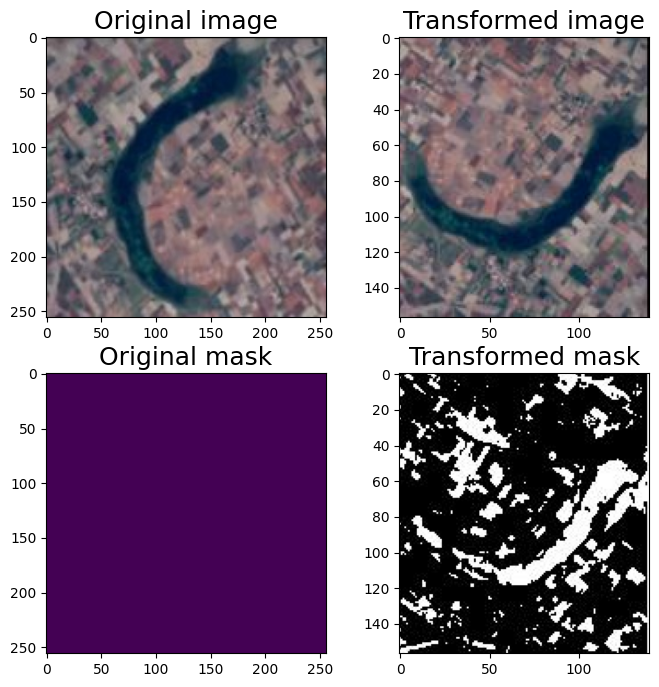

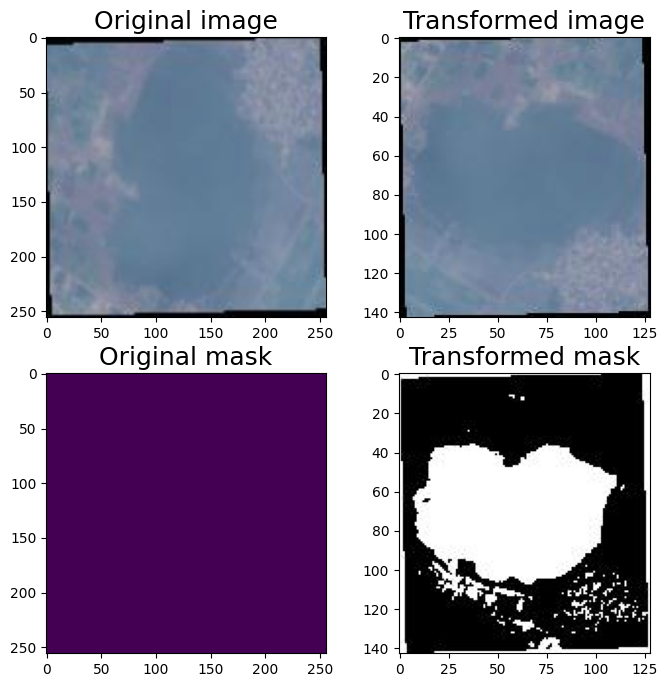

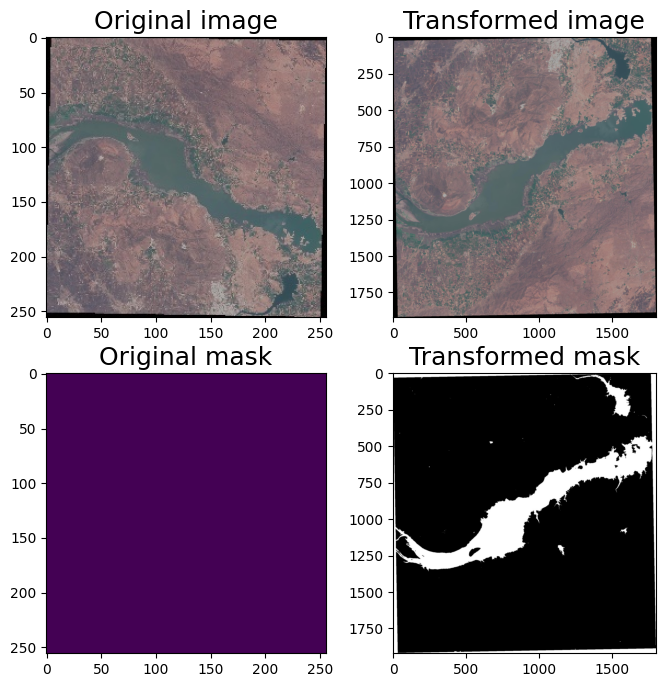

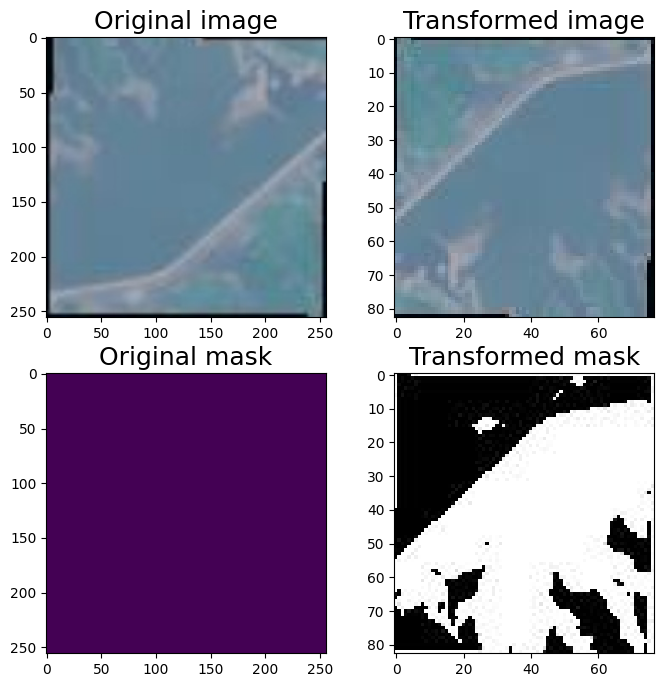

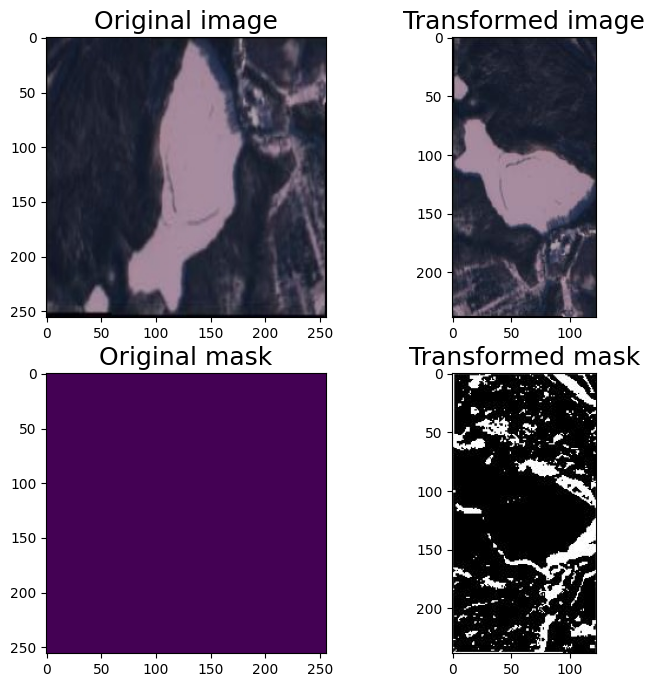

In [31]:
import random
import matplotlib.pyplot as plt

for i in range(5):
  idx=random.randint(0,len(train_dataset))
  showImageAndMask(idx)


In [ ]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2556
})

In [ ]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 285
})

In [ ]:

!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-emef0orq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-emef0orq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=7475eae74696c8d92368db9baafe8109a07c73c3e4c6fc22191be0f0f0936307
  Stored in directory: /tmp/pip-ephem-wheel-cache-nzvhoj48/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Create  dataset

In [ ]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    prompt = get_bounding_box(ground_truth_mask)
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

`AnnotionFormat` is deprecated and will be removed in v4.38. Please use `transformers.image_utils.AnnotationFormat` instead.


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
train_dataset = SAMDataset(dataset=train_dataset, processor=processor)

In [ ]:
len(train_dataset)

2556

## Create  DataLoader



In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler

dataset_size = len(train_dataset)
split = int(0.9 * dataset_size)
indices = list(range(dataset_size))

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=2, sampler=train_sampler, shuffle=False)
val_dataloader = DataLoader(train_dataset, batch_size=2, sampler=val_sampler, shuffle=False)


In [ ]:
len(train_dataloader)

1278

In [ ]:
len(val_dataloader)

143

Dataset({
    features: ['image', 'label'],
    num_rows: 2841
})

## Load the model

## Fine-tuning

In [ ]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

## Train the model

In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.2 MB/s eta 0:00:00


## Optimizer and Loss function

In [ ]:
from torch.optim import Adam
import monai
import torch.nn as nn
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

## define metrics

In [ ]:

def iou_metric(pred, target):
    intersection = torch.sum((pred * target).flatten())
    union = torch.sum((pred + target - pred * target).flatten())
    iou = intersection / union
    return iou.item()

def dice_coefficient(mask1, mask2):
    intersect = torch.sum(mask1*mask2)
    fsum = torch.sum(mask1)
    ssum = torch.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = torch.mean(dice)
    return dice

## Training

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
import os

num_epochs = 10
model.to(device)

# Find the latest existing model file
latest_model_path = None
start_epoch = 0

for epoch_num in range(num_epochs, 0, -1):
    model_path = f"drive/MyDrive/model_epoch_{epoch_num}.pt"
    if os.path.exists(model_path):
        latest_model_path = model_path
        start_epoch = epoch_num
        break

if latest_model_path is not None:
    # Load the latest model and continue training
    model.load_state_dict(torch.load(latest_model_path))
    print(f"Loaded model from {latest_model_path}.")
    print(f"Continuing training from epoch {start_epoch + 1}.")

model.train()
dices=[]
ious=[]
for epoch in range(start_epoch, num_epochs):
    epoch_losses = []

    for batch in tqdm(train_dataloader):
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks,  ground_truth_masks.unsqueeze(1))
        dice=dice_coefficient(predicted_masks,ground_truth_masks.unsqueeze(1))
        iou=iou_metric(predicted_masks,ground_truth_masks.unsqueeze(1))
        dices.append(dice)
        ious.append(iou)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print(f'Dice coefficient metric: {dice}')
    print(f'iou metric: {iou}')
    print(f'EPOCH: {epoch + 1}')
    print(f'Mean loss: {mean(epoch_losses)}')

    torch.save(model.state_dict(), f"drive/MyDrive/model_epoch_{epoch + 1}.pt")



Loaded model from drive/MyDrive/model_epoch_9.pt.
Continuing training from epoch 10.


100%|██████████| 1150/1150 [18:14<00:00,  1.05it/s]


Dice coefficient metric: tensor([-6.8739,  0.2637], device='cuda:0', grad_fn=<IndexPutBackward0>)
iou metric: tensor([[-0.7746],
        [ 0.1519]], device='cuda:0', grad_fn=<WhereBackward0>)
EPOCH: 10
Mean loss: 0.5125231067836284


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/model_checkpoint.pth")

In [ ]:
model.load_state_dict(torch.load("/content/model_checkpoint.pth"))


<All keys matched successfully>

# Eval

In [ ]:
def evaluate_pred(idx):
  image = val_dataloader.dataset.dataset[idx]["image"]
  image

  ground_truth_mask = np.array(val_dataloader.dataset.dataset[idx]["label"])
  prompt = get_bounding_box(ground_truth_mask)

  inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
  for k,v in inputs.items():
    print(k,v.shape)

  model.eval()

  with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)
  medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
  medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

  def show_mask(mask, ax, random_color=False):
      if random_color:
          color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
      else:
          color = np.array([30/255, 144/255, 255/255, 0.6])
      h, w = mask.shape[-2:]
      mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
      ax.imshow(mask_image)

  fig, axes = plt.subplots()

  axes.imshow(np.array(image))
  show_mask(medsam_seg, axes)
  axes.title.set_text(f"Predicted mask")
  axes.axis("off")

  fig, axes = plt.subplots()

  axes.imshow(np.array(image))
  show_mask(ground_truth_mask, axes)
  axes.title.set_text(f"Ground truth mask")
  axes.axis("off")

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


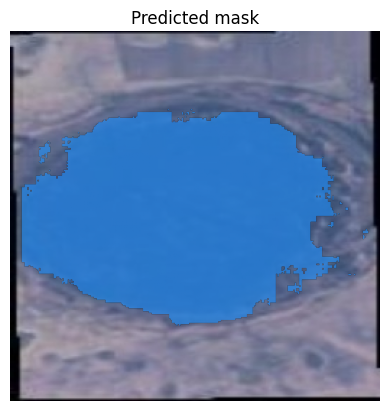

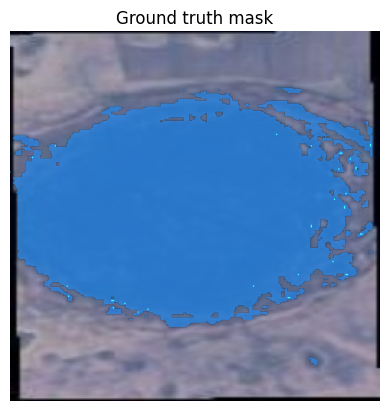

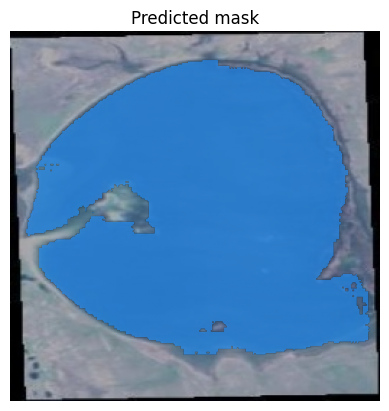

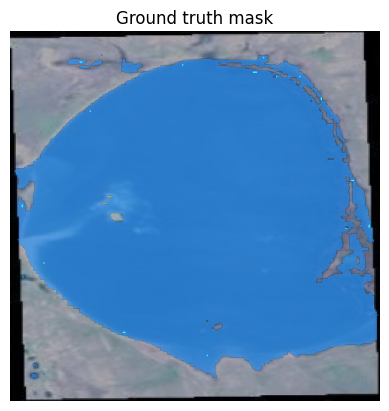

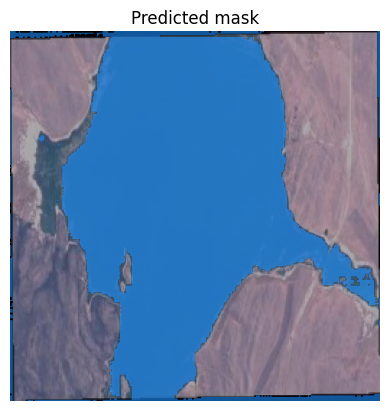

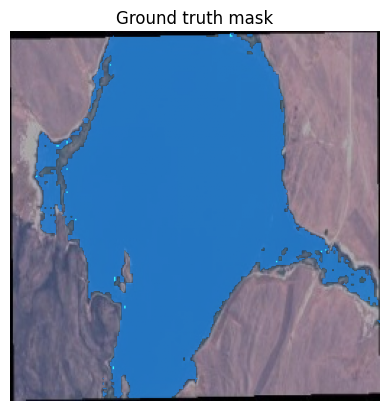

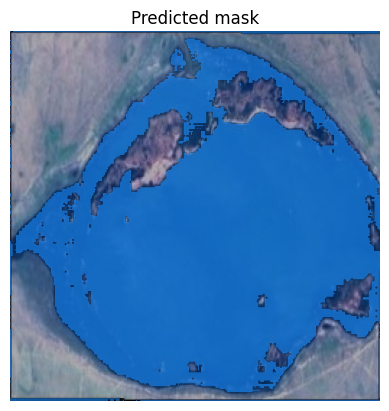

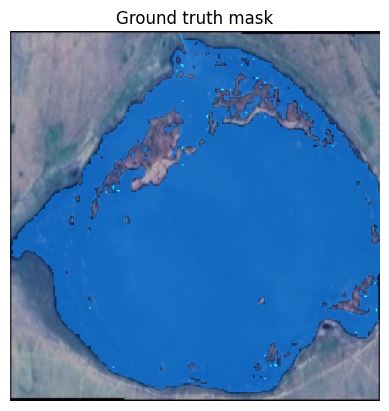

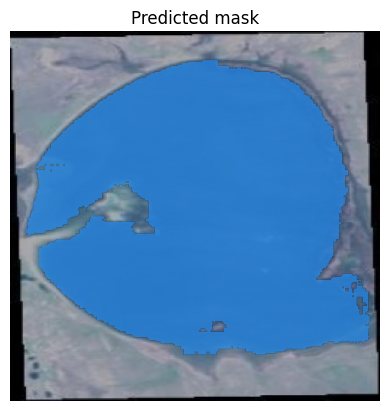

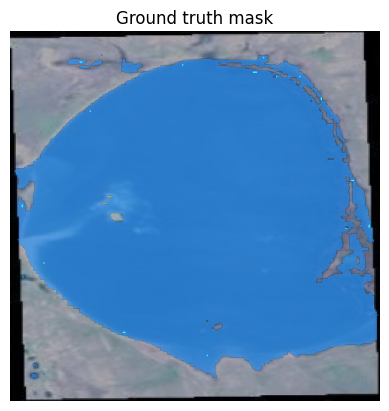

In [ ]:
import numpy as np
from PIL import Image
import random
idx=[]
for i in range(5):
  idx.append(random.randint(0,len(val_dataloader)))
  evaluate_pred(idx[i])


In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
def show_prob_mask(idx):
    test_image = val_dataloader.dataset.dataset[idx]["image"]

    ground_truth_mask = np.array(val_dataloader.dataset.dataset[idx]["label"])
    prompt = get_bounding_box(ground_truth_mask)

    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()

    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(np.array(test_image), cmap='gray')
    axes[0].set_title("Image")

    axes[1].imshow(medsam_seg, cmap='gray')
    axes[1].set_title("Mask")
    axes[2].imshow(medsam_seg_prob)
    axes[2].set_title("Probability Map")

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    plt.show()


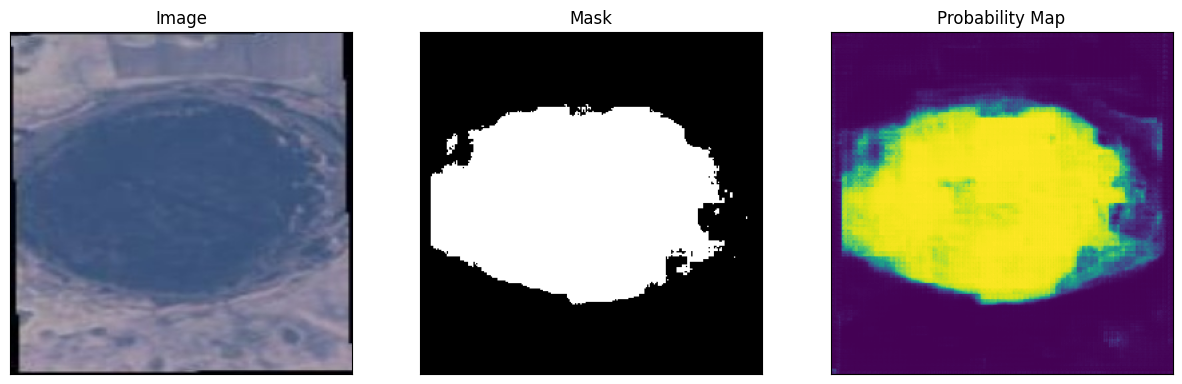

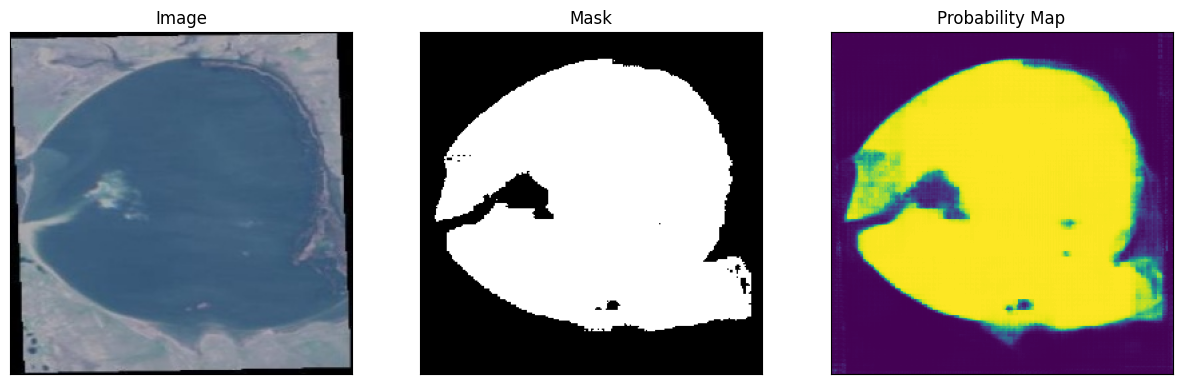

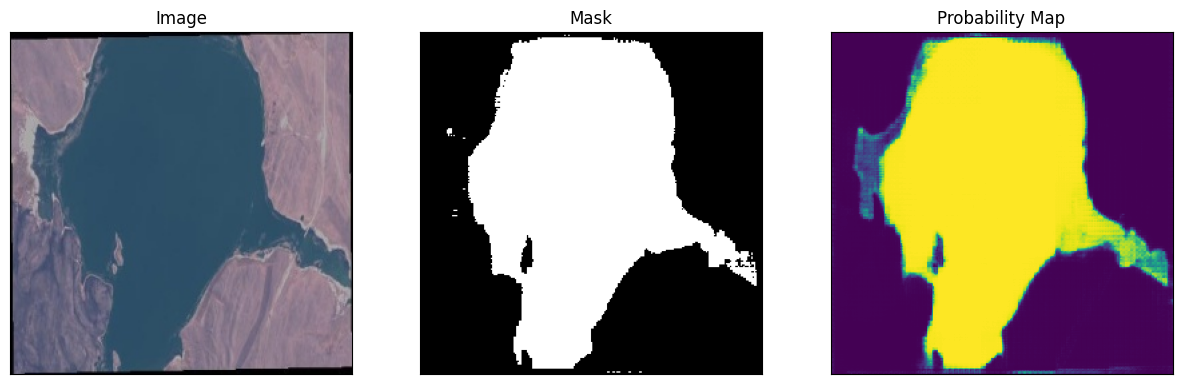

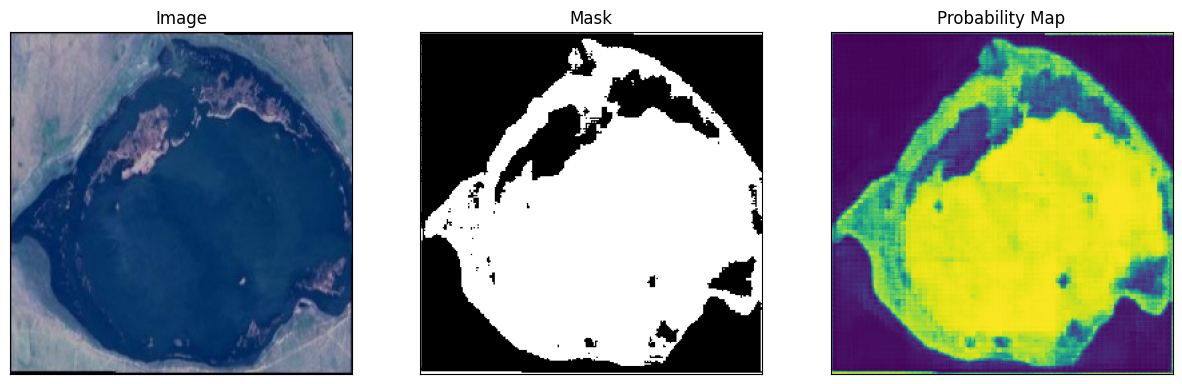

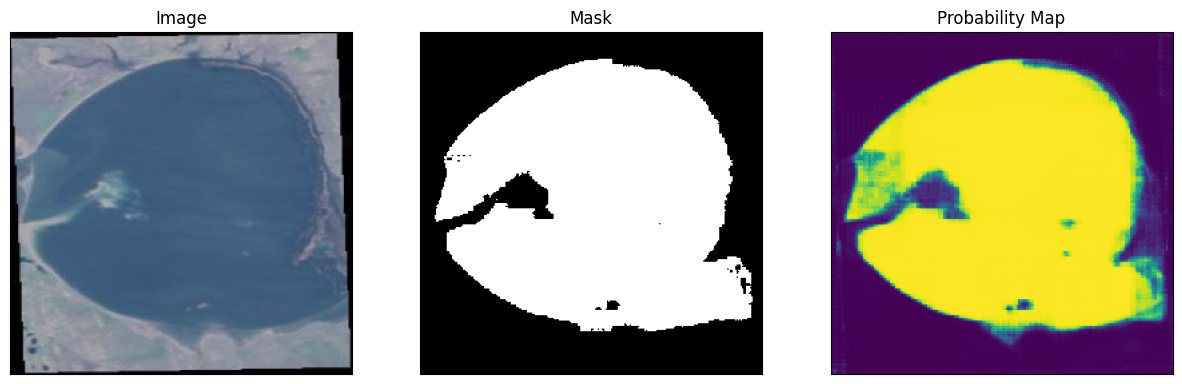

In [ ]:
for i in range(5):
  show_prob_mask(idx[i])